# Necessary Library

In [569]:
import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
from category_encoders.one_hot import OneHotEncoder

In [570]:
pd.set_option('mode.chained_assignment', None)

# 0. Upload data

In [571]:
data = pd.read_csv('../../data/data.csv')

In [572]:
# Any change on data will save in this dataframe to keep the origin in safe
data_ready = data.copy()

# 1. Understand your data

## Display head of Data

In [573]:
data_ready.head()

,Unnamed: 0,name,model,price,color,fuel_type,origin_car,car_license,lime_type,glass,...,payment_method,displayed,ex_owners,additional_info,insurance_third,supplementary_body,total,ads_status,ads_start_data,ads_end_data
0,0,كيا اوبتيما,2014,100000,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,...,نقدا فقط,للبيع فقط,يد اولى,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,فتحة سقف...",1340.0,1751.0,3090.0,منتهي,2017-08-16,2017-09-15
1,1,كيا سورينتو,2007,60000,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,...,إمكانية التقسيط,للبيع أو التبديل,2,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,فتحة سقف...",1690.0,1050.0,2740.0,منتهي,2017-08-16,2017-09-30
2,2,هونداي افانتي,2006,43500,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,...,نقدا فقط,للبيع فقط,NaN,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,جنطات مغ...",1340.0,1000.0,2340.0,منتهي,2017-08-19,2017-09-18
3,3,فيات 127,1982,5500,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,...,إمكانية التقسيط,للبيع فقط,00,"مُكيّف,مسجل CD",467.0,500.0,967.0,منتهي,2017-08-17,2017-09-22
4,4,بيجو 208,2014,54000,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,...,نقدا فقط,للبيع فقط,NaN,"مُكيّف,إغلاق مركزي,جهاز إنذار,جنطات مغنيسيوم,و...",1035.0,1000.0,2035.0,منتهي,2017-08-17,2017-10-01


- We have an Unnamed ID that we can delete
- Most of the columns are categorical

In [574]:
data_ready.columns

Index(['Unnamed: 0', 'name', 'model', 'price', 'color', 'fuel_type',
       'origin_car', 'car_license', 'lime_type', 'glass', 'motor_power',
       'car_speedometer', 'passengers', 'payment_method', 'displayed',
       'ex_owners', 'additional_info', 'insurance_third', 'supplementary_body',
       'total', 'ads_status', 'ads_start_data', 'ads_end_data'],
      dtype='object')

## Shape of data

In [575]:
data_ready.shape

(6161, 23)

## Decribe data

In [576]:
# Category features
data_ready.describe(include='O')

,name,color,fuel_type,origin_car,car_license,lime_type,glass,car_speedometer,passengers,payment_method,displayed,ex_owners,additional_info,ads_status,ads_start_data,ads_end_data
count,6161,6161,6161,6161,6161,6161,6161,4380,5447,6161,6161,4661,5715,6161,6161,6161
unique,596,26,3,6,2,3,2,1200,43,2,3,339,191,1,1442,1597
top,سكودا اوكتافيا,أبيض,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,100000,4+1,نقدا فقط,للبيع فقط,يد اولى,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,جنطات مغ...",منتهي,2019-09-28,2019-10-28
freq,446,1292,3594,5211,6090,3195,5662,90,4344,3863,3771,452,1100,6161,14,13


- We have 596 different automobile models, with the Skoda Octavia being the most popular.

- Car License, Origin Car, Glass, their unique value was replicated 6090 out of 6161, and it appears that it will be useless.

*This analysis before the question in the cars domains whether these variables will affect the price or not, the new analysis is that these variables have an impact, but it is not balanced.*

- Because the advertisements status has a unit value, it is useless.

In [577]:
# Numerical features
data_ready.describe()

,Unnamed: 0,model,price,motor_power,insurance_third,supplementary_body,total
count,6161.000000,6161.000000,6161.000000,6161.000000,6152.000000,6152.000000,6152.000000
mean,3080.000000,2008.229021,65293.567603,1740.785100,1148.600618,1244.490897,2392.950910
std,1778.671836,8.752494,56326.044654,589.016536,313.160799,899.502486,1080.223525
min,0.000000,1967.000000,1200.000000,106.000000,467.000000,500.000000,967.000000
25%,1540.000000,2005.000000,35000.000000,1400.000000,1035.000000,1000.000000,2035.000000
50%,3080.000000,2010.000000,54500.000000,1600.000000,1340.000000,1000.000000,2340.000000
75%,4620.000000,2015.000000,80000.000000,2000.000000,1340.000000,1401.000000,2740.000000
max,6160.000000,2021.000000,999999.000000,9000.000000,1690.000000,17500.000000,18535.000000


- Model is a category because it is a year, not a number.
- Insurance Third has skewed left
- Total and motor power feel normal
- Price has skewed right

## Basic Information

In [578]:
data_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6161 entries, 0 to 6160
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          6161 non-null   int64  
 1   name                6161 non-null   object 
 2   model               6161 non-null   int64  
 3   price               6161 non-null   int64  
 4   color               6161 non-null   object 
 5   fuel_type           6161 non-null   object 
 6   origin_car          6161 non-null   object 
 7   car_license         6161 non-null   object 
 8   lime_type           6161 non-null   object 
 9   glass               6161 non-null   object 
 10  motor_power         6161 non-null   int64  
 11  car_speedometer     4380 non-null   object 
 12  passengers          5447 non-null   object 
 13  payment_method      6161 non-null   object 
 14  displayed           6161 non-null   object 
 15  ex_owners           4661 non-null   object 
 16  additi

- We have 3 types of data (object, number and float)
- There are some missing values

# Handle Some Data Columns

### Handle Passengers Column

In [579]:
passengers:list = []

for row in data_ready['passengers']:
    sum_digit:int = 0
    if pd.isna(row):
        passengers.append(np.NaN)
        continue
    for char in str(row):
        if char.isdigit():
            int_char = int(char)
            sum_digit = sum_digit + int_char
    passengers.append(sum_digit)

data_ready['passengers'] = pd.Series(passengers).copy()
data_ready['passengers'].unique()

array([ 5.,  8., nan,  6.,  7.,  3.,  1.,  4.,  2.,  9.,  0., 10.])

### Handle ex_owner Column 

In [580]:
data_ready['ex_owners'].unique()

array(['يد اولى ', '2 ', nan, '00  ', '0 ', '1 ', 'يد ثانية ', '4 ',
       'يد ثانيه ', '3 ', 'ثالثة ', 'غير منمر استيراد الماني ', '00 ',
       'غير منمرة ', 'أولى ', '٨ ', 'يد اولا ', 'يد ثالثة ', 'يد ثالثة  ',
       'ثانية ', 'يد أولى ', 'يد سادسة ', '5 ', 'اولى  ', 'صفر ', '9 ',
       '0000 ', 'رابعه ', 'يد أولى  ', '٤ ', 'يد رابعة  ', '٢ ',
       'يد ثالثه ', '6 ', 'يد اولى  ', '7 ', '... ', 'يد ثانيه  ',
       'يد أولى استيراد ', 'يد اولي 1 ', 'اولى ', '...... ', 'ثانيه ',
       'واحد ', 'اربعة ', 'اولا ', '٣ ', 'غير منمره ', 'يد تالته ', '٦ ',
       'يد رابعه ', 'يد ثالثة ( فتيات) ', '159000 ', '12 ', '- ',
       'مش منمر ', '0 مستورده ', 'يد تانيه ', '10 ', 'يد 1 ', 'مستورد ',
       'يد 4 ', 'يد رابعة ', '00000 ', '١ ', 'استيراد مباشر من كوريا  ',
       'يد خامسة ', '٥ ', 'يد 5 ', '******** ', 'نعم ', 'مش منمرة  ',
       'يد 3 ', ' يد ثانيه ', 'يداولى ', '4  ', 'يد أولى وكالة ',
       'يد خامسه ', 'يد ثانية  ', '٩ ', '٧ ', 'يدو اولى ', 'للبيع  ',
       '8 ', 'يد و

In [581]:
""" ex_owner is Dictionary contains:
'number name' as key : [the number, all words that indicates for the number from ex_owner unique]
"""
ex_owner:dict = {
    'Nan_numaric': [np.NaN, '78888877766', '159000', '170000', '123423', '12345', '1000', '11111', '778244', '١٨', '١١', '١٢', '١٥', '١٧'],
    'Nan_value' : [np.NaN, '\x89', '.','*' , '@', '؟', '-' ,'،', '?', 'اشخاص', 'مس', 'شطب', 'E', 'مشطوب', 'خصوصي', 'للبيع', 'نعم', 'منمره'],
    'zero': ['0', '٠', 'صفر', 'صفرض', 'صفرر', 'لا شيء ','Zero','O', 'Ooo', 'غير مرخصة', 'سحب', 'اصل',
             'مستورد', 'استيراد', 'مستوردة', 'استراد', 'مستورده', 'وارد', 'أستيراد' ],
    'ones' : ['1', 'أولى', 'اولى', 'اولا', 'واحد', 'اول', 'ياولى', 'اوله', 'انا','اولي', 'واله', 'ولا', 'واحدة', 'أولئ', 'ولى',
              'أولي', 'اولئ', 'اولة', 'اةلي', '١'],
    'ones_2':['1', 'غير منمرة', 'مش', 'لا يوجد','لا يوجد ', 'لايوجد','غير','لا يوجد', 'يد ا', 'ا' , 'يد'],
    'two' : ['2', 'تانيه', 'ثني', 'تاني', 'ثاتيه', 'تانية', 'ثاني', 'ثانبه', 'تانبه', 'ثانيا',
             'يانيه', 'ثانية', 'ثانيه', 'اثنان', '٢'],
    'three' : ['3', 'ثالثة', 'ثالثه', 'تالثه', 'تالته', 'ثالث', 'التالته', '٣'],
    'four'  : ['4', 'اربعه', 'رابعه', 'اربعة', 'رابعة','٤'],
    'five'  : ['5', 'خامسة', 'خامسه', 'خامساً', 'خمسة', 'خمسه', '٥'],
    'six'   : ['6', 'سادسة', '٦'],
    'seven' : ['7', 'سابعة', 'سابعه', '٧'],
    'eight' : ['8', 'ثامنه', 'ثمانيه', '٨'],
    'nighn' : ['9', 'تاسعة', '٩'],
    'ten'   : ['10', 'عاشره', '١٠']
   
}

In [582]:
def handle_ex_owner(search_list:list):
    """It search the index of row string match in the search_list

    Args:
        search_list (list): contains all unique value from ex_owner column
            that indicates to specific number

    Returns:
        index (list): contains all indexes found in search_list
    """
    index:list = []
    for search_word in search_list:
        search_word = str(search_word)
        count = 0
        for item in data_ready['ex_owners']:
            item = str(item)
            split_item = item.split(' ')
            for split_item_index in range(len(split_item)):
                if search_word in split_item[split_item_index]:
                    index.append(count)
            count += 1
    return index

In [583]:
# mapping the row string to right number (or NAN)
for key, value_list in enumerate(ex_owner.values()):
    data_ready['ex_owners'].iloc[handle_ex_owner(value_list)] = float(value_list[0])

In [584]:
# Display the unique values
data_ready['ex_owners'].unique()

array([1.0, 2.0, nan, 0.0, 4.0, 3.0, 8.0, 5.0, 9.0, 6.0, 7.0],
      dtype=object)

### Handle car_speedometer Column

In [585]:
data_ready['car_speedometer']

0        75000 
1       130000 
2           NaN
3         شغال 
4        38000 
         ...   
6156    180000 
6157        NaN
6158     25000 
6159       110 
6160     60479 
Name: car_speedometer, Length: 6161, dtype: object

It has numbers, string and NaN

In [586]:
def handle_car_speedometer(car_speedometer: list):
    """Handle Inconsisty data for car_speedometer column.

    Args:
        car_speedometer (list): car_speedometer column from data_ready dataframe

    Returns:
        car_speedometer (list): Modified (Handled) car_speedometer column list
    """
    index:int = 0
    for item in car_speedometer:
        item = str(item).split(' ')
        for item_index in range(len(item)): 
            if item[item_index].isdigit():
                car_speedometer.iloc[index] = int(item[item_index])
                break
            if item_index == len(item)-1:
                car_speedometer.iloc[index] = np.NaN
        index += 1
    return car_speedometer

In [587]:
# Handled car_speedometer column
data_ready['car_speedometer'] = handle_car_speedometer(data_ready['car_speedometer'])

In [588]:
# Display car_speedometer uniaue value
data_ready['car_speedometer'].unique()

array([75000, 130000, nan, 38000, 123456, 50000, 56000, 460000, 45000,
       70000, 79000, 0, 150, 210000, 1, 20000, 113000, 33000, 22000,
       150000, 29000, 123457, 250000, 140000, 122000, 78000, 900000, 7,
       65000, 190, 184000, 200, 30000, 295000, 60000, 143212, 43000, 71,
       160000, 4000, 121000, 9900, 260, 80, 200000, 60, 124000, 100000,
       90000, 99, 82000, 32123123, 120, 166000, 275000, 82700, 123000,
       120000, 500000, 18000000, 80000, 87000, 110000, 350000, 700000, 55,
       400000, 35000, 380000, 167000, 140, 160, 123456789, 111111, 94000,
       90, 46000, 82, 51, 280000, 115, 300000, 41000, 196000, 274000,
       2000, 136000, 116000, 13700, 132, 54000, 40, 72000, 12345, 133000,
       157, 47, 71000, 132000, 180000, 47000, 999855, 52000, 5, 30,
       165500, 40000, 256664, 109000, 100, 39000, 190000, 113500, 74000,
       2000000, 91000, 620, 51000, 1600, 1111111, 363636, 220, 490000,
       48000, 159000, 68000, 950000, 93000, 290090, 58000, 36000, 8

### Handle date columns

In [589]:
# Convert the date columns to datetime columns
for feature in ['ads_start_data', 'ads_end_data']:
    data_ready[feature] = pd.to_datetime(data_ready[feature])

## Duplicates

In [590]:
# Find the duplicates
data_ready.duplicated().sum()

0

thers no duplicates values

## Data type for data

In [591]:
data_ready.dtypes

Unnamed: 0                     int64
name                          object
model                          int64
price                          int64
color                         object
fuel_type                     object
origin_car                    object
car_license                   object
lime_type                     object
glass                         object
motor_power                    int64
car_speedometer               object
passengers                   float64
payment_method                object
displayed                     object
ex_owners                     object
additional_info               object
insurance_third              float64
supplementary_body           float64
total                        float64
ads_status                    object
ads_start_data        datetime64[ns]
ads_end_data          datetime64[ns]
dtype: object

# 2. Preparation and transformation

## Handle missing values

In [592]:
# Get the columns that has at least one nan value
data_ready[data_ready.columns[data_ready.isna().any()]].isna().sum()

car_speedometer       1915
passengers             714
ex_owners             1632
additional_info        446
insurance_third          9
supplementary_body       9
total                    9
dtype: int64

In [593]:
# For this iteration I will not handle additional_info column in professional way
data_ready['additional_info'].fillna("No additional value", inplace=True)

In [594]:
# Re-get the columns that has at least one nan value
data_ready.columns[data_ready.isna().any()]

Index(['car_speedometer', 'passengers', 'ex_owners', 'insurance_third',
       'supplementary_body', 'total'],
      dtype='object')

### Use knn for fill missing of numeric columns

In [595]:
# Define the columns that will enter the imputer
features_imputer = ['car_speedometer', 'supplementary_body', 'insurance_third', 'total']

# Define imputer
imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')

# Fit on the dataset
imputer.fit(data_ready[features_imputer])

# Transform the dataset
data_ready[features_imputer] = imputer.transform(data_ready[features_imputer])

In [596]:
# Re-get the columns that has at least one nan value
data_ready.columns[data_ready.isna().any()]

Index(['passengers', 'ex_owners'], dtype='object')

### Use mode value for specific columns

In [597]:
# Fill columns with its mode value
data_ready['passengers'].fillna(value=data_ready['passengers'].mode().values[0], inplace=True)
data_ready['ex_owners'].fillna(value=data_ready['ex_owners'].mode().values[0], inplace=True)

In [598]:
# Re-get the columns that has at least one nan value
data_ready.columns[data_ready.isna().any()]

Index([], dtype='object')

## Drop useless columns

In [599]:
# Delete the Unnamed ID column
data_ready.drop(columns="Unnamed: 0", inplace=True)

In [600]:
# Delete ads_status column
data_ready.drop('ads_status', axis=1, inplace=True)

In [601]:
# Delete insurance columns
data_ready.drop(columns=['insurance_third', 'supplementary_body', 'total'], inplace=True)

### Rename columns 

In [602]:
# Dictionary contains the previous name column and what I want the column name set to
feature_rename = {
    'origin_car':'car_type',
    'car_license': 'license_type',
    'glass': 'glass_type',
    'displayed': 'display_purpose',
    'ads_start_data': 'ads_start_date',
    'ads_end_data': 'ads_end_date'
}

# Rename specific columns based on the feature_name dictionary
data_ready.rename(columns=feature_rename, inplace=True)

# Display the columns after rename 
data_ready.columns

Index(['name', 'model', 'price', 'color', 'fuel_type', 'car_type',
       'license_type', 'lime_type', 'glass_type', 'motor_power',
       'car_speedometer', 'passengers', 'payment_method', 'display_purpose',
       'ex_owners', 'additional_info', 'ads_start_date', 'ads_end_date'],
      dtype='object')

### Display Correlations between Numaric Features

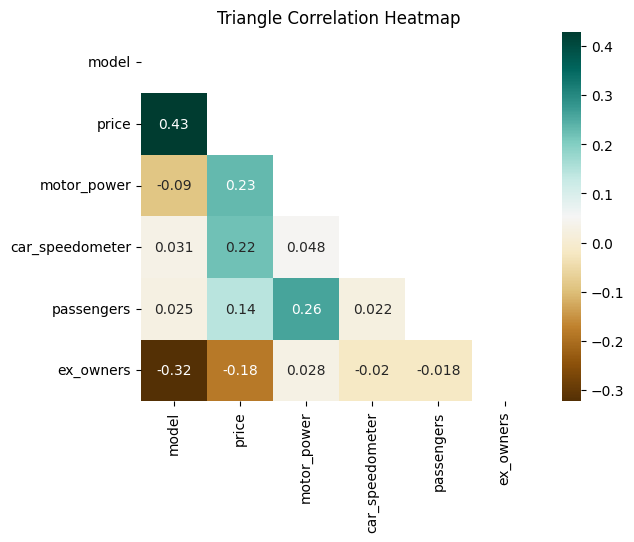

In [603]:
# Display the correlation between all features
mask = np.triu(np.ones_like(data_ready.select_dtypes(include='number').corr()))
heatmap = sns.heatmap(data_ready.select_dtypes(include='number').corr(), mask=mask,\
    annot=True, cmap='BrBG').set_title('Triangle Correlation Heatmap')
plt.show()

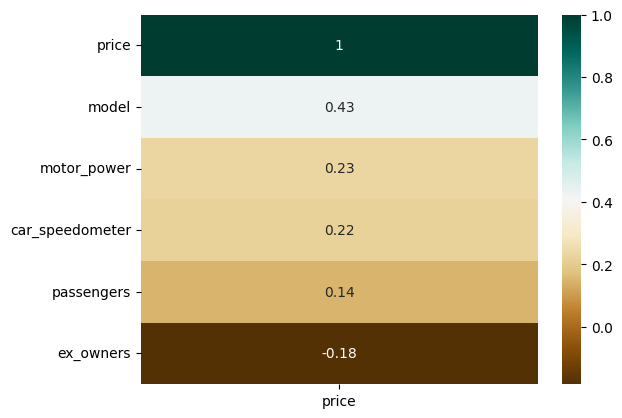

In [604]:
# Display the correlation between target variable (price) with all other numaric features 
heatmap = sns.heatmap(data_ready.select_dtypes(include='number').corr()[['price']].\
    sort_values(by='price', ascending=False), annot=True, cmap='BrBG')

### Display Correlations between Category Features

In [605]:
# Create dataframe to display the arabic label name in right format for plotting
display_data = data_ready.copy()
for feature in display_data.select_dtypes(include='object').columns:
    temp = []
    for row in display_data[feature]:
        temp.append(get_display(arabic_reshaper.reshape(row)))
    temp = pd.Series(temp)
    display_data[feature] = temp

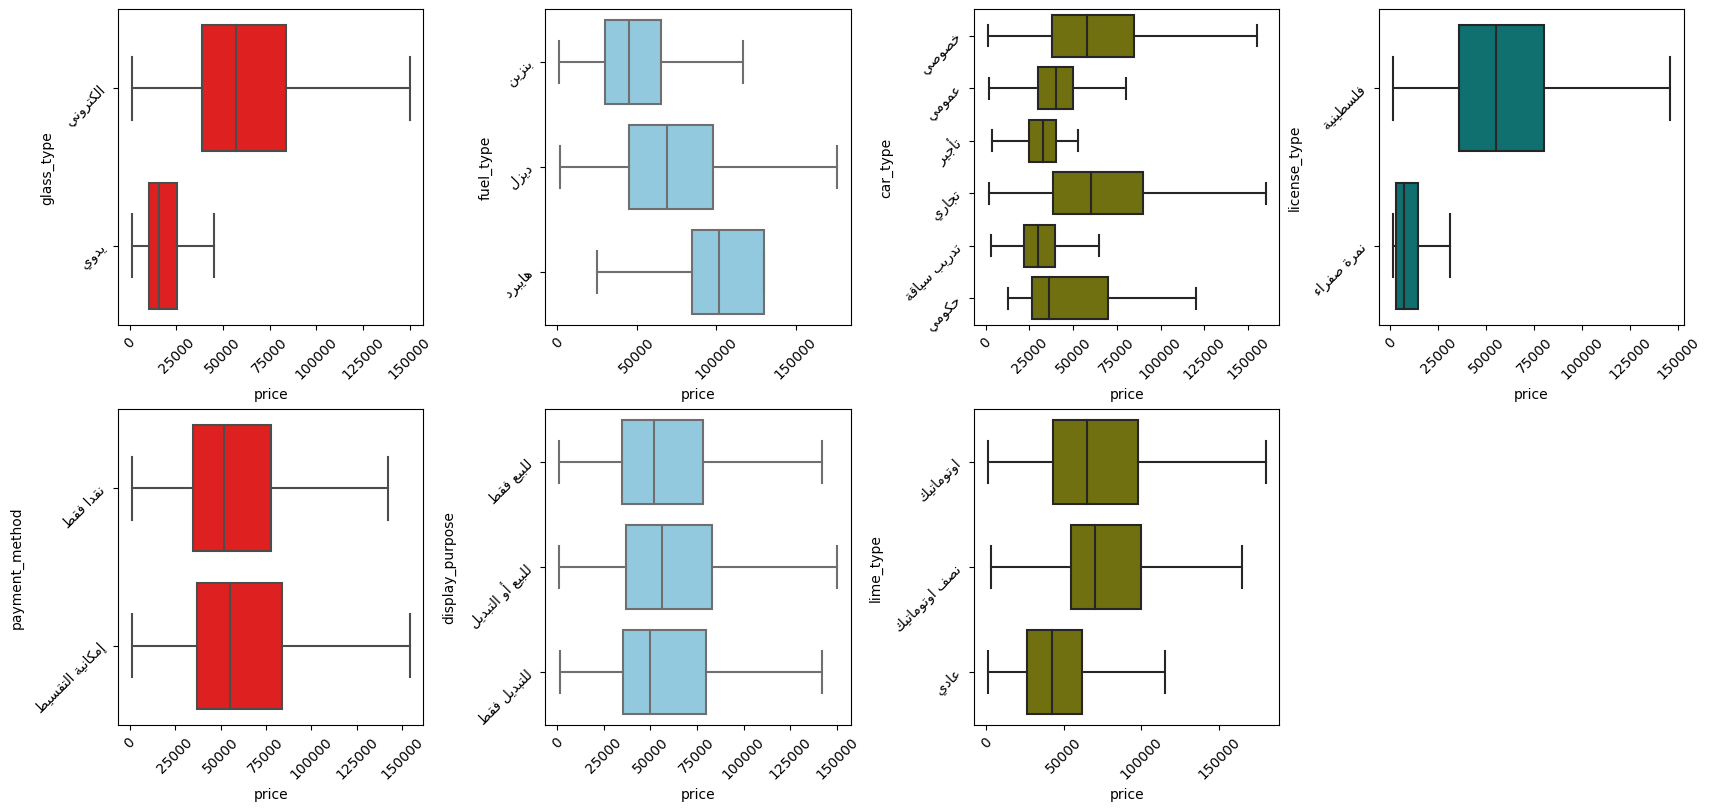

In [608]:
# Display the boxplot between each category column and price column
fig, axs = plt.subplots(2, 4, figsize=(17, 8), constrained_layout = True)

sns.boxplot( x=display_data["price"],y=display_data["glass_type"], color="red", ax=axs[0, 0], showfliers=False).tick_params(axis='both', rotation=45)
sns.boxplot( x=display_data["price"],y=display_data["fuel_type"], color="skyblue", ax=axs[0, 1], showfliers=False).tick_params(axis='both', rotation=45)
sns.boxplot( x=display_data["price"],y=display_data["car_type"], color="olive", ax=axs[0, 2], showfliers=False).tick_params(axis='both', rotation=45)
sns.boxplot( x=display_data["price"],y=display_data["license_type"], color="teal", ax=axs[0, 3], showfliers=False).tick_params(axis='both', rotation=45)

sns.boxplot( x=display_data["price"],y=display_data["payment_method"], color="red", ax=axs[1,0], showfliers=False).tick_params(axis='both', rotation=45)
sns.boxplot( x=display_data["price"],y=display_data["display_purpose"], color="skyblue", ax=axs[1,1], showfliers=False).tick_params(axis='both', rotation=45)
sns.boxplot( x=display_data["price"],y=display_data["lime_type"], color="olive", ax=axs[1, 2], showfliers=False).tick_params(axis='both', rotation=45)
fig.delaxes(axs[1,3])

plt.show()

1. glass column: Electronic windows will affect the car price.
2. fuel_type column: Hybrid fuel will affect the car price.
3. origin_car column: The types of cars that affect the price are: commercial, private, and public.
4. car_license column: The type of car license that will affect the price is the Palestinian license.
5. payment_method and displayed columns: The difference in payment types is essentially non-existent, thus it will have little effect on the car's pricing.
6. lime_type column: The type of regular lime has no effect on the pricing, unlike other types.

# 3. Univariate analysis

## Numaric columns

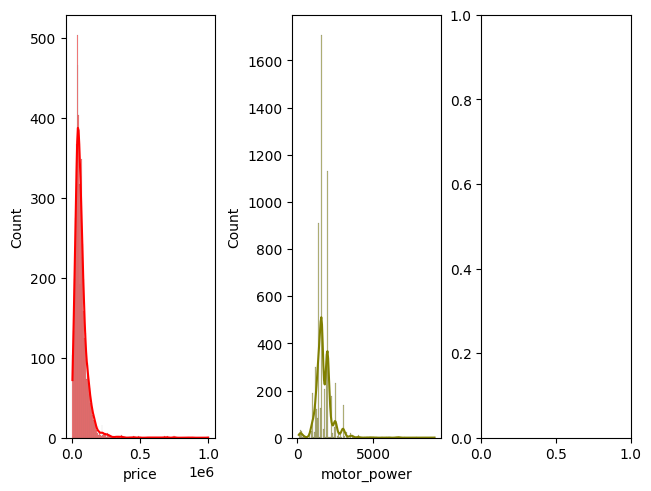

In [610]:
# Display Numaric columns
fig, axs = plt.subplots(1, 3, constrained_layout = True)

sns.histplot(data=data_ready, x="price", kde=True, color="red", ax=axs[0])
sns.histplot(data=data_ready, x="motor_power", kde=True, color="olive", ax=axs[1])
# car_speedometer column will rais MemoryError because it has huge number (outlier)
#sns.histplot(data=data_ready, x="car_speedometer", kde=True, color="gold", ax=axs[2])

plt.show()

## Handle Outlier for some numaric columns

In [611]:
def handle_outlier(column):
    # Find quartile 3 of column
    q3 = data_ready[column].quantile(0.75)

    # Find quartile 1 of column
    q1 = data_ready[column].quantile(0.25)

    # Find IQR
    IQR = q3 - q1

    # Find the upper and lower outlier number
    upper_outlier = q3 + IQR * 1.5
    lower_outlier = q1 - IQR * 1.5

    # Replace all outlier to the max and min quartile number 
    data_ready.loc[data_ready[column] > upper_outlier, column] = upper_outlier
    data_ready.loc[data_ready[column] < lower_outlier, column] = lower_outlier


In [612]:
# Handle outlier for numarice columns
handle_outlier('price')
handle_outlier('motor_power')
handle_outlier('car_speedometer')

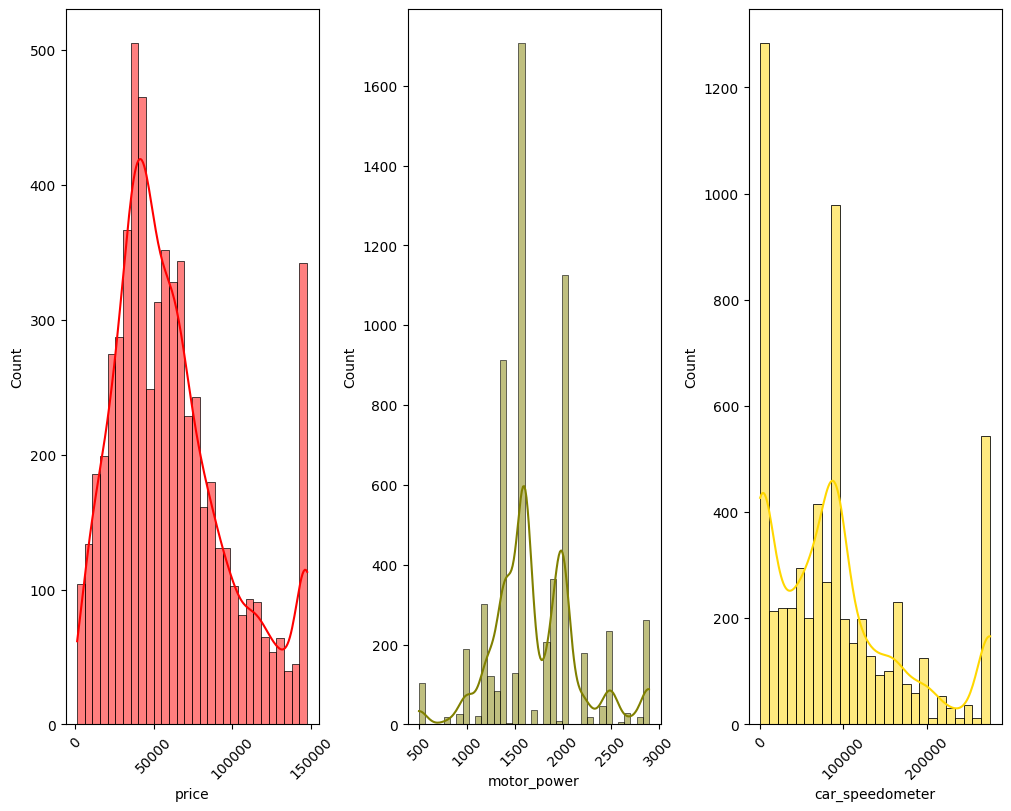

In [613]:
# Display the numaric handled columns
fig, axs = plt.subplots(1, 3, figsize=(10, 8), constrained_layout = True)

sns.histplot(data=data_ready, x="price", kde=True, color="red", ax=axs[0]).tick_params(axis='x', rotation=45)
sns.histplot(data=data_ready, x="motor_power", kde=True, color="olive", ax=axs[1]).tick_params(axis='x', rotation=45)
sns.histplot(data=data_ready, x="car_speedometer", kde=True, color="gold", ax=axs[2]).tick_params(axis='x', rotation=45)

plt.show()

## Category Columns

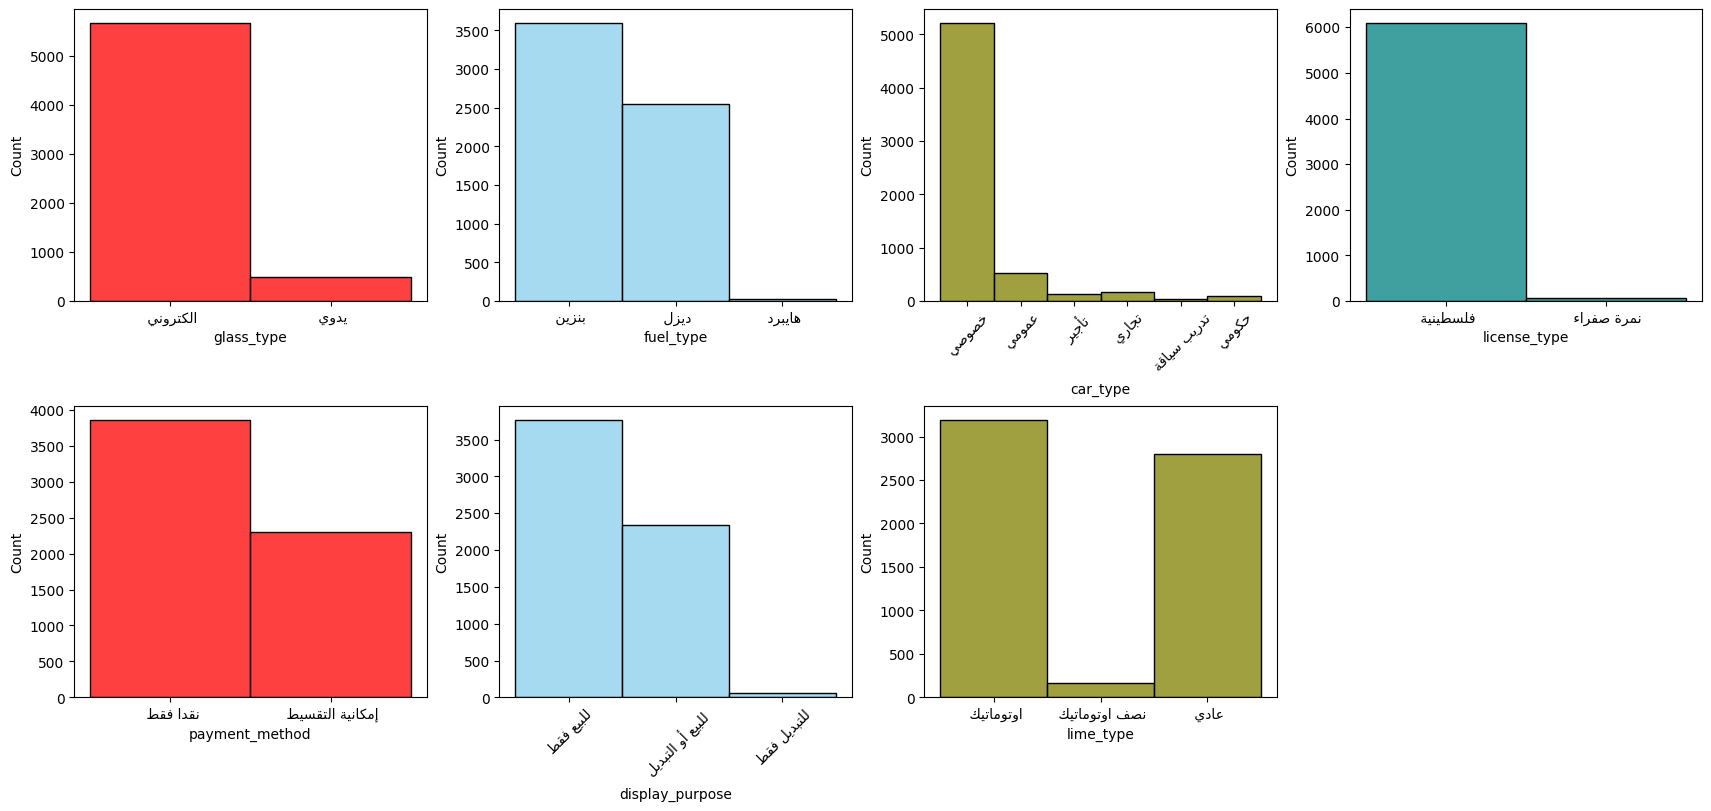

In [616]:
# Display category columns
fig, axs = plt.subplots(2, 4, figsize=(17, 8), constrained_layout = True)

sns.histplot(data=display_data, x="glass_type", color="red", ax=axs[0, 0])
sns.histplot(data=display_data, x="fuel_type", color="skyblue", ax=axs[0, 1])
sns.histplot(data=display_data, x="car_type", color="olive", ax=axs[0, 2]).tick_params(axis='x', rotation=45)
sns.histplot(data=display_data, x="license_type", color="teal", ax=axs[0, 3])

sns.histplot(data=display_data, x="payment_method", color="red", ax=axs[1,0])
sns.histplot(data=display_data, x="display_purpose", color="skyblue", ax=axs[1,1]).tick_params(axis='x', rotation=45)
sns.histplot(data=display_data, x="lime_type", color="olive", ax=axs[1, 2])


fig.delaxes(axs[1,3])

plt.show()

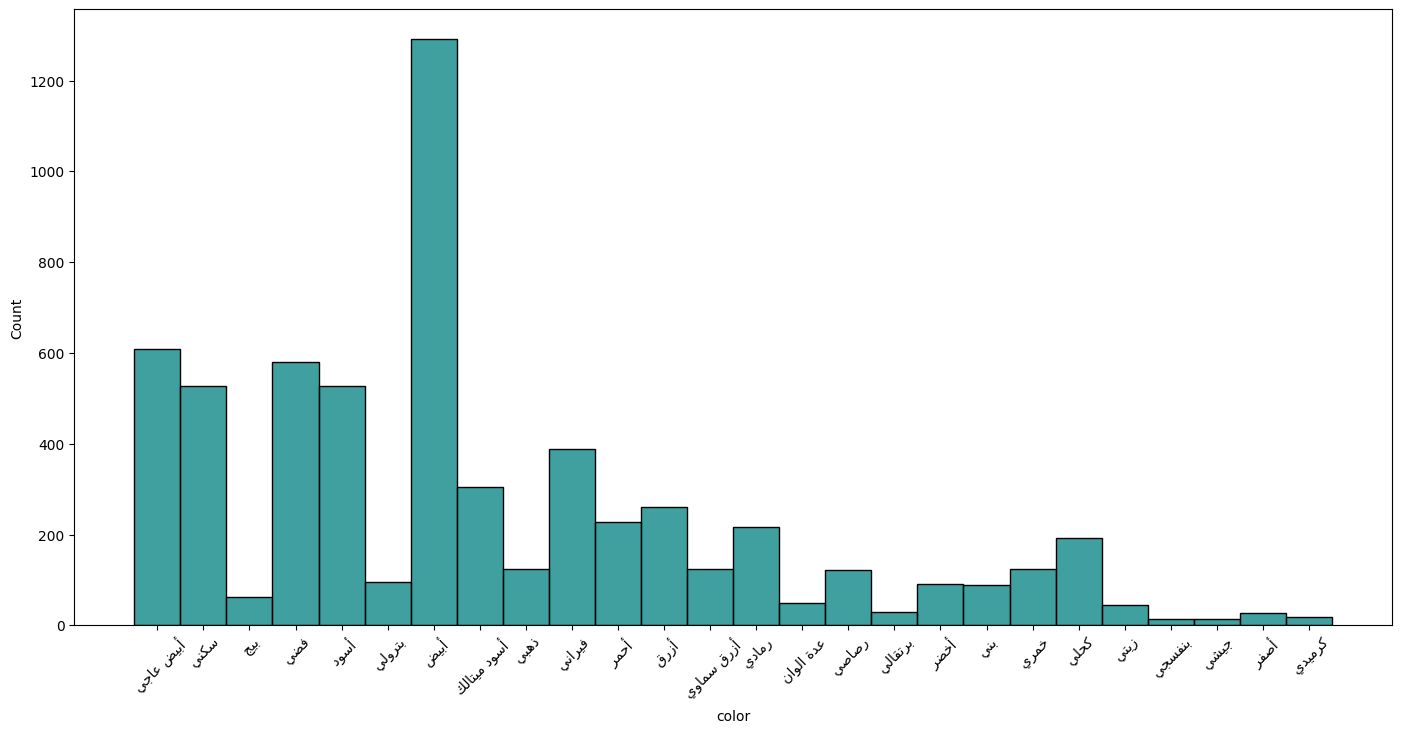

In [617]:
# Display color column
plt.subplots(figsize=(17, 8))
sns.histplot(data=display_data, x="color", color="teal").tick_params(axis='x', rotation=45)
plt.show()

In [259]:
# Create metadata dictionary for category information
# Its primary objective is to store numbers and the text values 
# that they represent in category features.
#category_metadata = {}

# Get the codes with its for color category
#category_metadata['color'] = dict(enumerate(data_ready['color'].astype('category').cat.categories))

# Get the codes for color category
#data_ready['color'] = data_ready['color'].astype('category').cat.codes

In [260]:
# Create metadata dictionary for category information
# Its primary objective is to store numbers and the text values 
# that they represent in category features.
#category_metadata = {}

# Get the codes with its for color category
#category_metadata['color'] = dict(enumerate(data_ready['color'].astype('category').cat.categories))

# Get the codes for color category
#data_ready['color'] = data_ready['color'].astype('category').cat.codes

## Time Series columns

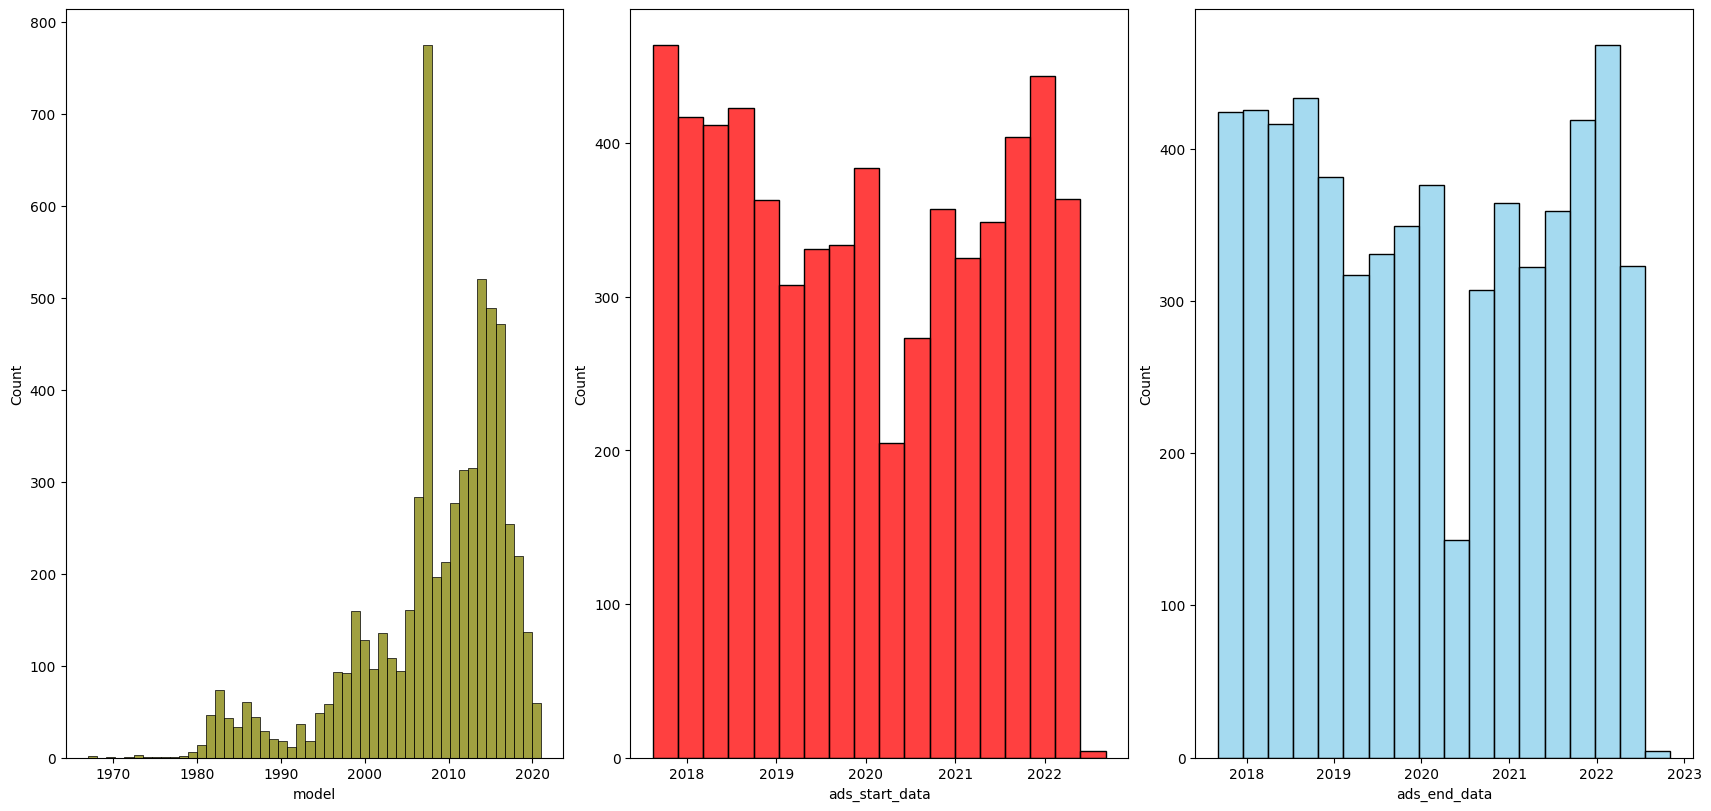

In [267]:
fig, axs = plt.subplots(1, 3, figsize=(17, 8), constrained_layout = True)
sns.histplot(data=display_data, x="model", color="olive", ax=axs[0])
sns.histplot(data=display_data, x="ads_start_data", color="red", ax=axs[1])
sns.histplot(data=display_data, x="ads_end_data", color="skyblue", ax=axs[2])
plt.show()

In [638]:
# Conert the timestamp columns to quarter number of timestamp
data_ready['ads_start_date'] = pd.DatetimeIndex(data_ready['ads_start_date']).quarter
data_ready['ads_end_date'] = pd.DatetimeIndex(data_ready['ads_end_date']).quarter

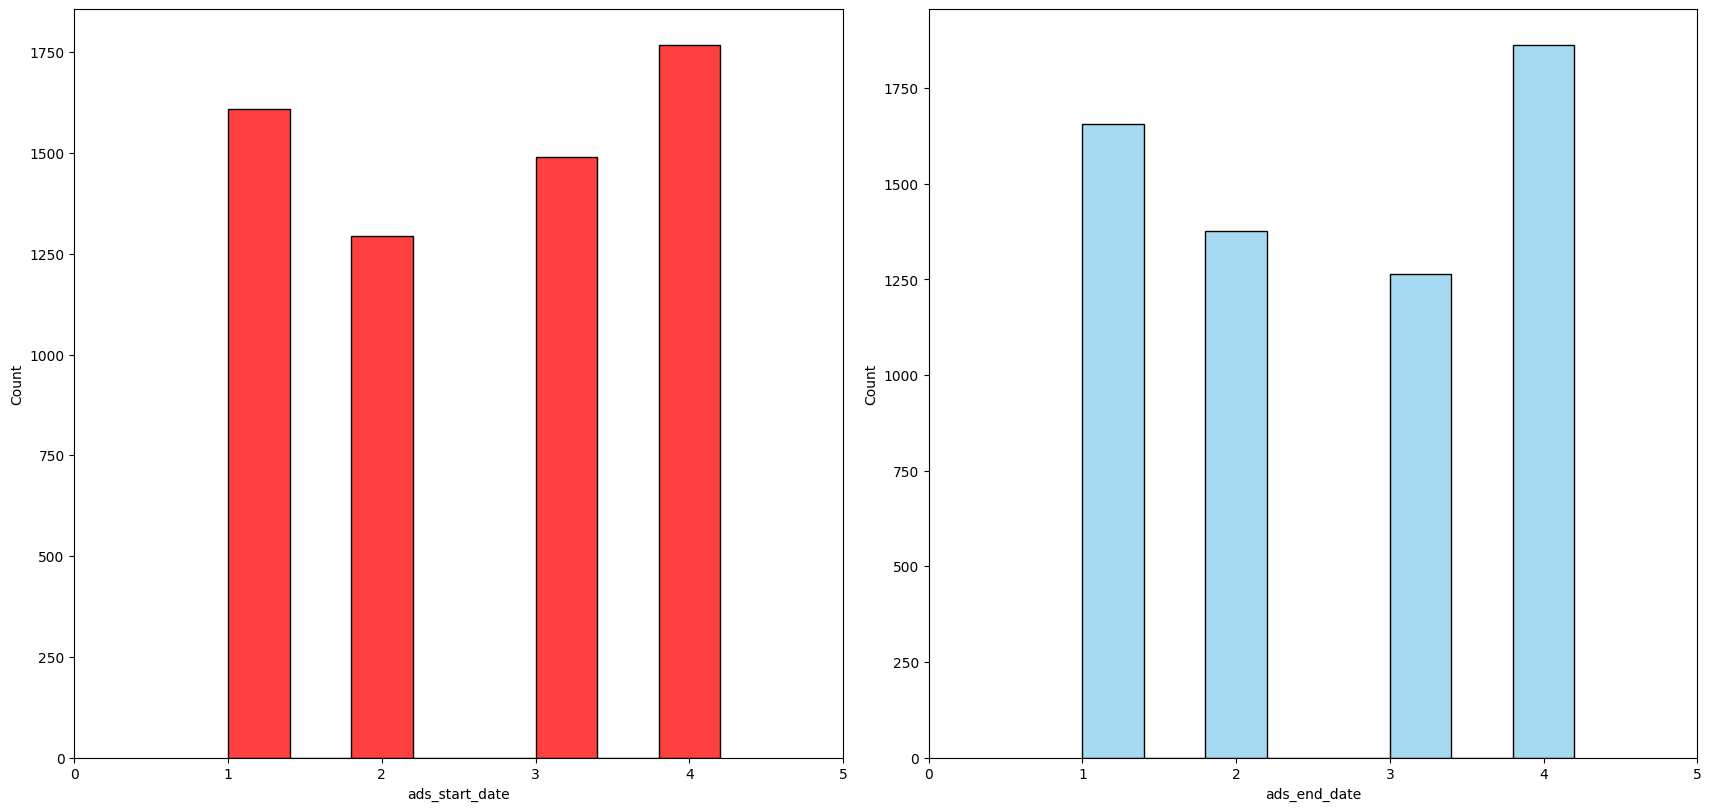

In [654]:
# Display quarter after converted
fig, axs = plt.subplots(1, 2, figsize=(17, 8), constrained_layout = True)
sns.histplot(data=data_ready, x="ads_start_date", color="red", binwidth=0.4, ax=axs[0]).set_xlim(0,5)
sns.histplot(data=data_ready, x="ads_end_date", color="skyblue", binwidth=0.4, ax=axs[1]).set_xlim(0,5)
plt.show()

# 4. Multivariate analysis

# 5. Convert Category columns to Numaric
by One hot encoding

In [ ]:
# Name of columns required one hot encoding
one_hot_features = ['name', 'color', "glass_type", "fuel_type", "car_type", "license_type", "lime_type", "payment_method", "display_purpose"]

# Create object of OneHotEncoder
onehot_encoder = OneHotEncoder(use_cat_names=True)

# One hot encoding for columns (column in one_hot_features list)
features_encoded = onehot_encoder.fit_transform(data_ready[one_hot_features])

# Delete the origin column
data_ready.drop(one_hot_features,  axis=1, inplace=True)

# Convert the features_encoded to dataframe
features_encoded = pd.DataFrame(features_encoded, columns = onehot_encoder.get_feature_names())

# Concatenate the two dataframe
data_ready = pd.concat([data_ready, features_encoded], axis=1)

c:\Users\DELL\OneDrive\Documents\capo\ML\ML Projects\Predict-Car-Price\.venv\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\DELL\OneDrive\Documents\capo\ML\ML Projects\Predict-Car-Price\.venv\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\DELL\OneDrive\Documents\capo\ML\ML Projects\Predict-Car-Price\.venv\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\DELL\OneDrive\Documents\capo\ML\ML Projects\Predict-Car-Price\.venv\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and wil

In [ ]:
# Display first 2 row
data_ready.head(2)

,model,price,motor_power,car_speedometer,passengers,ex_owners,additional_info,ads_start_date,ads_end_date,name_كيا اوبتيما,...,license_type_فلسطينية,license_type_نمرة صفراء,lime_type_اوتوماتيك,lime_type_نصف اوتوماتيك,lime_type_عادي,payment_method_نقدا فقط,payment_method_إمكانية التقسيط,display_purpose_للبيع فقط,display_purpose_للبيع أو التبديل,display_purpose_للتبديل فقط
0,2014,100000,2000,75000.0,5.0,1.0,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,فتحة سقف...",2017-08-16,2017-09-15,1,...,1,0,1,0,0,1,0,1,0,0
1,2007,60000,2500,130000.0,8.0,2.0,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,فتحة سقف...",2017-08-16,2017-09-30,0,...,1,0,0,1,0,0,1,0,1,0


In [ ]:
# Display the columns name
data_ready.columns

Index(['model', 'price', 'motor_power', 'car_speedometer', 'passengers',
       'ex_owners', 'additional_info', 'ads_start_date', 'ads_end_date',
       'name_كيا اوبتيما',
       ...
       'license_type_فلسطينية ', 'license_type_نمرة صفراء ',
       'lime_type_اوتوماتيك ', 'lime_type_نصف اوتوماتيك ', 'lime_type_عادي ',
       'payment_method_نقدا فقط ', 'payment_method_إمكانية التقسيط ',
       'display_purpose_للبيع فقط ', 'display_purpose_للبيع أو التبديل ',
       'display_purpose_للتبديل فقط '],
      dtype='object', length=652)